<small><i>This notebook was put together by [Jake Vanderplas](http://www.vanderplas.com). Source and license info is on [GitHub](https://github.com/jakevdp/sklearn_tutorial/).</i></small>

# Supervised Learning In-Depth: Random Forests

Previously we saw a powerful discriminative classifier, **Support Vector Machines**.
Here we'll take a look at motivating another powerful algorithm. This one is a *non-parametric* algorithm called **Random Forests**.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn')

## Motivating Random Forests: Decision Trees

Random forests are an example of an *ensemble learner* built on decision trees.
For this reason we'll start by discussing decision trees themselves.

Decision trees are extremely intuitive ways to classify or label objects: you simply ask a series of questions designed to zero-in on the classification:

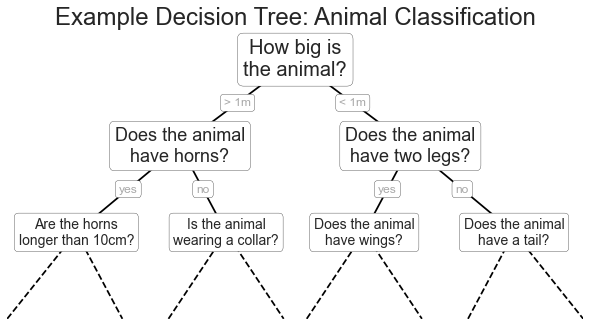

In [2]:
import fig_code
fig_code.plot_example_decision_tree()

The binary splitting makes this extremely efficient.
As always, though, the trick is to *ask the right questions*.
This is where the algorithmic process comes in: in training a decision tree classifier, the algorithm looks at the features and decides which questions (or "splits") contain the most information.

### Creating a Decision Tree

Here's an example of a decision tree classifier in scikit-learn. We'll start by defining some two-dimensional labeled data:

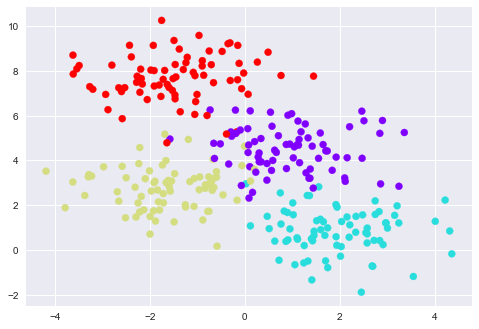

In [3]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=1.0)
                  
fig, ax = plt.subplots()

ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow');

We have some convenience functions in the repository that help 

In [4]:
from fig_code import visualize_tree, plot_tree_interactive

Now using IPython's ``interact`` (available in IPython 2.0+, and requires a live kernel) we can view the decision tree splits:

In [5]:
plot_tree_interactive(X, y);

interactive(children=(IntSlider(value=1, description='depth', max=5, min=1), Output()), _dom_classes=('widget-…

Notice that at each increase in depth, every node is split in two **except** those nodes which contain only a single class.
The result is a very fast **non-parametric** classification, and can be extremely useful in practice.

**Question: Do you see any problems with this?**

### Decision Trees and over-fitting

One issue with decision trees is that it is very easy to create trees which **over-fit** the data. That is, they are flexible enough that they can learn the structure of the noise in the data rather than the signal! For example, take a look at two trees built on two subsets of this dataset:

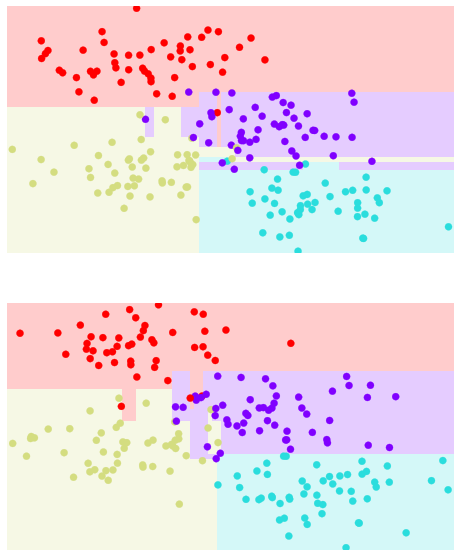

In [6]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()

fig, ax = plt.subplots(nrows=2, figsize=(8,10))

visualize_tree(clf, X[:200], y[:200], boundaries=False, ax=ax[0])
visualize_tree(clf, X[-200:], y[-200:], boundaries=False, ax=ax[1])

The details of the classifications are completely different! That is an indication of **over-fitting**: when you predict the value for a new point, the result is more reflective of the noise in the model rather than the signal.

## Ensembles of Estimators: Random Forests

One possible way to address over-fitting is to use an **Ensemble Method**: this is a meta-estimator which essentially averages the results of many individual estimators which over-fit the data. Somewhat surprisingly, the resulting estimates are much more robust and accurate than the individual estimates which make them up!

One of the most common ensemble methods is the **Random Forest**, in which the ensemble is made up of many decision trees which are in some way perturbed.

There are volumes of theory and precedent about how to randomize these trees, but as an example, let's imagine an ensemble of estimators fit on subsets of the data. We can get an idea of what these might look like as follows:

In [7]:
def fit_randomized_tree(random_state=0):
    X, y = make_blobs(n_samples=300, centers=4,
                      random_state=0, cluster_std=2.0)
    clf = DecisionTreeClassifier(max_depth=15)
    
    rng = np.random.default_rng(random_state)
    i = np.arange(len(y))
    rng.shuffle(i)

    fig, ax = plt.subplots()

    visualize_tree(clf, X[i[:250]], y[i[:250]], boundaries=False, ax=ax,
                   xlim=(X[:, 0].min(), X[:, 0].max()),
                   ylim=(X[:, 1].min(), X[:, 1].max()))
    
from ipywidgets import interact
interact(fit_randomized_tree, random_state=(0, 100));

interactive(children=(IntSlider(value=0, description='random_state'), Output()), _dom_classes=('widget-interac…

See how the details of the model change as a function of the sample, while the larger characteristics remain the same!
The random forest classifier will do something similar to this, but use a combined version of all these trees to arrive at a final answer:

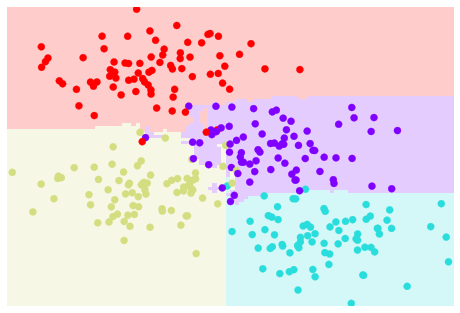

In [8]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=0)

fig, ax = plt.subplots()

visualize_tree(clf, X, y, boundaries=False, ax=ax);

By averaging over 100 randomly perturbed models, we end up with an overall model which is a much better fit to our data!

*(Note: above we randomized the model through sub-sampling... Random Forests use more sophisticated means of randomization, which you can read about in, e.g. the [scikit-learn documentation](http://scikit-learn.org/stable/modules/ensemble.html#forest)*)

## Quick Example: Moving to Regression

Above we were considering random forests within the context of classification.
Random forests can also be made to work in the case of regression (that is, continuous rather than categorical variables). The estimator to use for this is ``sklearn.ensemble.RandomForestRegressor``.

Let's quickly demonstrate how this can be used:

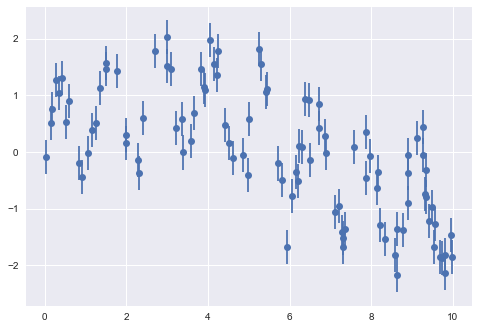

In [9]:
from sklearn.ensemble import RandomForestRegressor

rng = np.random.default_rng(seed=0)

x = 10 * rng.random(100)

def model(x, sigma=0.3):
    fast_oscillation = np.sin(5 * x)
    slow_oscillation = np.sin(0.5 * x)
    noise = sigma * np.random.randn(len(x))

    return slow_oscillation + fast_oscillation + noise

y = model(x)

fig, ax = plt.subplots()

ax.errorbar(x, y, 0.3, fmt='o');

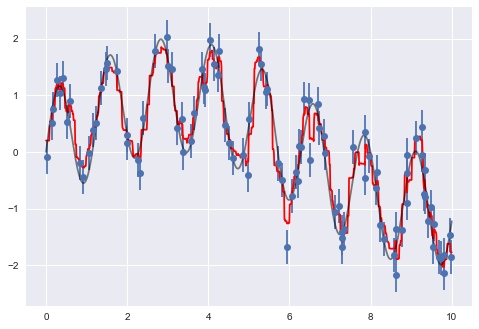

In [10]:
xfit = np.linspace(0, 10, 1000)
yfit = RandomForestRegressor(100).fit(x[:, None], y).predict(xfit[:, None])
ytrue = model(xfit, 0)

fig, ax = plt.subplots()

ax.errorbar(x, y, 0.3, fmt='o')
ax.plot(xfit, yfit, '-r');
ax.plot(xfit, ytrue, '-k', alpha=0.5);

As you can see, the non-parametric random forest model is flexible enough to fit the multi-period data, without us even specifying a multi-period model!

## Example: Random Forest for Classifying Digits

We previously saw the **hand-written digits** data. Let's use that here to test the efficacy of the SVM and Random Forest classifiers.

In [11]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

In [12]:
X = digits.data
y = digits.target
print(X.shape)
print(y.shape)

(1797, 64)
(1797,)


To remind us what we're looking at, we'll visualize the first few data points:

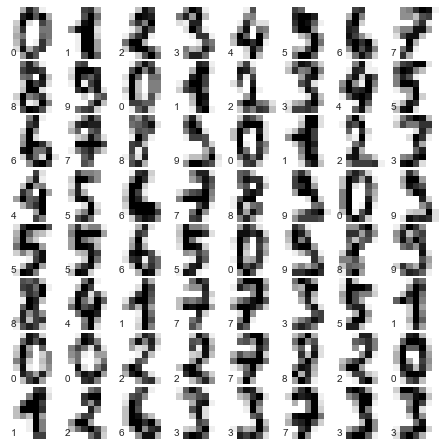

In [13]:
# set up the figure
fig = plt.figure(figsize=(6, 6))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# plot the digits: each image is 8x8 pixels
for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest')
    
    # label the image with the target value
    ax.text(0, 7, str(digits.target[i]))

We can quickly classify the digits using a decision tree as follows:

In [14]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=0)
clf = DecisionTreeClassifier(max_depth=11)
clf.fit(Xtrain, ytrain)
ypred = clf.predict(Xtest)

We can check the accuracy of this classifier:

In [15]:
metrics.accuracy_score(ypred, ytest)

0.8377777777777777

and for good measure, plot the confusion matrix:

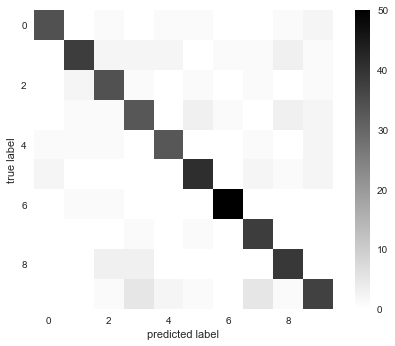

In [16]:
fig, ax = plt.subplots()

matrix = ax.imshow(metrics.confusion_matrix(ypred, ytest),
           interpolation='nearest', cmap=plt.cm.binary)
ax.grid(False)
fig.colorbar(matrix)
ax.set_xlabel("predicted label")
ax.set_ylabel("true label");

### Exercise
1. Repeat this classification task with ``sklearn.ensemble.RandomForestClassifier``.  How does the ``max_depth``, ``max_features``, and ``n_estimators`` affect the results?
2. Try this classification with ``sklearn.svm.SVC``, adjusting ``kernel``, ``C``, and ``gamma``. Which classifier performs optimally?
3. Try a few sets of parameters for each model and check the F1 score (``sklearn.metrics.f1_score``) on your results. What's the best F1 score you can reach?